In [1]:
!pip install flask


     -------------------------------------- 101.7/101.7 kB 3.0 MB/s eta 0:00:00
     -------------------------------------- 226.8/226.8 kB 7.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [22/Apr/2024 23:24:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2024 23:24:30] "GET /static/style.css HTTP/1.1" 404 -
127.0.0.1 - - [22/Apr/2024 23:24:30] "GET /static/plot.png HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2024 23:24:30] "GET /favicon.ico HTTP/1.1" 404 -


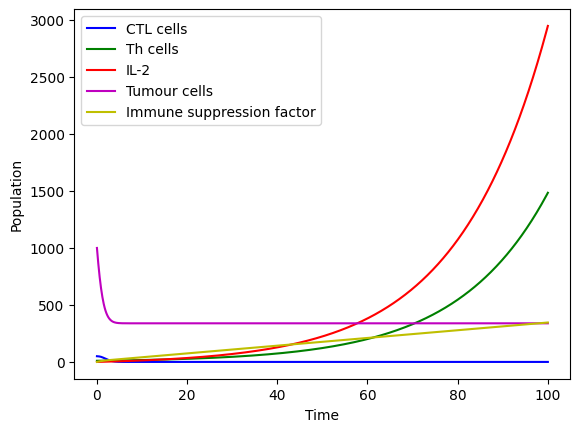

In [4]:
from flask import Flask, render_template, request
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

app = Flask(__name__)

# Define the model
def model(y, t, rC, dC, rH, kIL, kCT, s, K):
    C, H, IL, T, S = y
    dCdt = rC * C * (1 - (T/K)) * (1 - S) - dC * C
    dHdt = rH * H
    dILdt = kIL * H
    dTdt = -kCT * C * T
    dSdt = s * T
    return [dCdt, dHdt, dILdt, dTdt, dSdt]


# Define the route for the homepage
@app.route('/', methods=['GET', 'POST'])
def home():
    # Default values for the model parameters
    rC = 0.1
    dC = 0.05
    rH = 0.05
    kIL :float=0.1
    kCT = 0.01
    s = 0.01
    K = 1000

    # If the form has been submitted, update the parameters
    if request.method == 'POST':
        rC = float(request.form.get('rC', 0.1))
        dC = float(request.form.get('dC', 0.05))
        rH = float(request.form.get('rH', 0.05))
        kIL = float(request.form.get('kIL', 0.1))
        kCT = float(request.form.get('kCT', 0.01))
        s = float(request.form.get('s', 0.01))
        K = float(request.form.get('K', 1000))

    # Integrate the model with the updated parameters
    t = np.linspace(0, 100, 1000)
    y0 = [50, 10, 0, 1000, 0]
    sol = odeint(model, y0, t, args=(rC, dC, rH, kIL, kCT, s, K))

    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(t, sol[:,0], 'b', label='CTL cells')
    ax.plot(t, sol[:,1], 'g', label='Th cells')
    ax.plot(t, sol[:,2], 'r', label='IL-2')
    ax.plot(t, sol[:,3], 'm', label='Tumour cells')
    ax.plot(t, sol[:,4], 'y', label='Immune suppression factor')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.legend()
    plt.savefig('static/plot.png')

    # Render the homepage template with the current parameters and the graph
    return render_template('index.html', rC=rC, dC=dC, rH=rH, kIL=kIL, kCT=kCT, s=s, K=K)

# Define the route for the results page
@app.route('/results')
def results():
    # Render the results template with the graph
    return render_template('results.html')

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)